In [12]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

from collections import Counter
import numpy as np
from copy import deepcopy
from joblib import delayed, Parallel

import seaborn as sns

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl

import mne
mne.set_log_level('CRITICAL')
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 

from mne.preprocessing.bads import find_outliers

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import ridge_regression, Ridge

from os import listdir

montage_file = "./tools/standard.elp"

def get_name(inst):
    i_ = inst
    spl = ("-" if "-" in i_ else "_")
    name = str(int(i_.split("/")[-1].split("_")[2]))
    return name

# Determine events

In [16]:
def get_df(events):
    fname = "../samir_mktrgs.csv"
    df = pd.read_csv(fname).ix[1:]
    df["s_depth"] = np.log(pd.to_numeric(df["xmin"], errors="coerce"))
    df["xmin"] = pd.to_numeric(df["xmin"], errors="coerce") * 100
    df = df[np.isfinite(df['xmin'])]
    df["word"] = 1
    df["local_pred"] = df["freq"] * df["local_freq"]
    for t, _, s in events:
        df.loc[df["story"] == s, "xmin"] += t
    df["xmin"] = df["xmin"].astype(int)
    return df

def shift_events(events, subj):
    logstr = "../logs/GS_EEG_0{subj:02d}-Gesture_Story_Sce_Part{block}.log"
    times = []
    for block in (1, 2):
        fname = logstr.format(subj=subj, block=block)
        with open(fname, 'r') as f:
            s = f.read().split("ReqDur")[2].split("filename")[0]

        from io import StringIO
        names = ["x", "y", "EventType", "Code", "Type", "Response" "RT", "RT Uncertainty", "Time"
                 "Uncertainty", "Duration", "Uncertainty", "ReqTime", "ReqDur"]
        df = pd.read_csv(StringIO(s), sep="\t", names=names)
        times += list(df.query("x == 'Video'")["TimeUncertainty"])

    for ii, time in enumerate(times):
        events[ii, 0] += time // 10

    return events

def do_sdepth(df):
    filldict = dict()

    v = 0
    for x, y in df['story'].value_counts().sort_index().iteritems():
        filldict[x] = v
        v += y
    filldict

    df['sdepthlin'] = np.arange(len(df))
    df['sdepthlin'] -= df['story'].map(filldict)
#    df['sdepthlin'] = np.log1p(df['sdepthlin'])
    return df

In [17]:
from sklearn.preprocessing import MinMaxScaler, minmax_scale
s = MinMaxScaler((0, 1))

def make_covs(raw, subj, do_freqs=False, events=None):
    keys = [
            "word",
            'index_s',
            "new_sentence",
            "first_sentence",
            "last_sentence",
            "sdepthlin",
            "last_word",
            "length",
           ]
    if events is None:
        events = mne.find_events(raw, stim_channel='STI 014',
                                shortest_event=1, consecutive=True)
        events[:, 2] = events[:, 2] - 20
        events = events[events[:, 2] > 0]

        events = shift_events(events, subj)

    df = get_df(events)
    df["new_sentence"] = df["index_s"] < 2
    df['isN'] = df['POS_word'] == 'N'
    df["first_sentence"] = df["story"].diff() != 0
    df["last_sentence"] = list(df["story"].diff() != 0)[1:] + [True]
    df = do_sdepth(df)
    df["last_word"] = list(df["index_s"] == 1)[1:] + [True]
    df["freqXlocal_freq"] = df["freq"] * df["local_freq"]
    
    df.loc[df["freq"] == 30, "freq"] = 26
    df["Freq"] = (df["freq"].rank().rank(pct=True) * 100).astype(int) + 1
    freqs = pd.get_dummies(df["freq"])
    freqs = freqs.rename({ii: "Freq/" + str(int(ii)) for ii in freqs.columns}, axis=1)
    if do_freqs:
        keys += list(freqs.columns)
    else:
        keys += ['freq']
    df = df.join(freqs)

    df["Length"] = (df["length"].rank().rank(pct=True) * 5).astype(int) + 1
    freqs = pd.get_dummies(df["Length"])
    freqs = freqs.rename({ii: "Length/" + str(ii) for ii in freqs.columns}, axis=1)
    df = df.join(freqs)
    
    df["lenXfreq"] = df["length"] * df["freq"]
    
    covs = df.fillna(0).sort_values("xmin")

    keys = [k for k in keys if k in covs.columns]
    covariates = covs[keys]
    events2 = covs[["xmin", "xmin", "word"]].astype(int).values

    return events2, covariates

# Run the actual regression

In [19]:
from mne.stats.regression import linear_regression_raw as rerp
def make_rerp(fname, do_freqs=False):
    subj = int(fname.split("/")[-1].split("-")[0])
    print(subj, end=' ')
    raw = mne.io.read_raw_fif(fname, preload=True).filter(None, 12)
    events, covs = make_covs(raw, subj, do_freqs=do_freqs)
    ica = mne.preprocessing.ica.read_ica(fname.replace("raw", "ica"))
    ica.exclude = list(ica.labels_["blinks"]) + list(ica.labels_["saccade"])
    raw = ica.apply(raw, exclude=ica.exclude)
    raw.drop_channels(["Eog"])
    for c in covs.keys():
        if len(set(covs[c])) > 2:
            covs[c] = s.fit_transform((covs[c].reshape(-1, 1)).astype(float)).flatten()
    return rerp(raw, events, event_id=dict(),
                covariates=covs,
                tmin=-1.,
                tmax=2.,
                solver=lambda X, y: Ridge(alpha=1, fit_intercept=False).fit(X, y).coef_
               )

In [20]:
fifloc = "../"
from glob import glob
fifs = list(sorted(glob(fifloc +  "*-raw.fif*")))

In [21]:
raw = mne.io.read_raw_fif(fifs[0], preload=True).filter(None, 12).pick_types(eeg=True).drop_channels(["Eog"])

In [22]:
rerps_freqs = Parallel(n_jobs=-1)(delayed(make_rerp)(fname, do_freqs=False) for fname in fifs)
rerps_bins = Parallel(n_jobs=-1)(delayed(make_rerp)(fname, do_freqs=True) for fname in fifs)

11 2 1 20 19 18 9 12 3 

In [23]:
grands = {cond:mne.grand_average([rp[cond] for rp in rerps_freqs]) for cond in rerps_freqs[0]}
grands_bins = {cond:mne.grand_average([rp[cond] for rp in rerps_bins]) for cond in rerps_bins[0]}

# Plotting

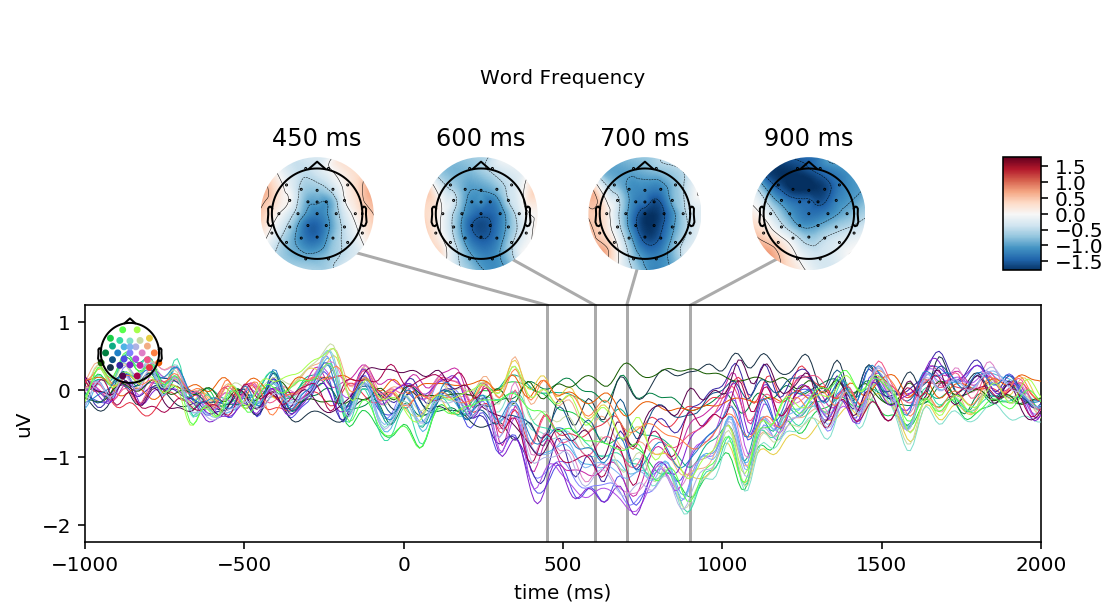

In [24]:
ts_args = dict(ylim=dict(eeg=(-2.25, 1.25)))
f = grands["freq"].plot_joint(title="Word Frequency", times=[.45, .6, .7, .9],
                              ts_args=ts_args);
#f.savefig("../figs/samir_freq_butterfly.pdf")

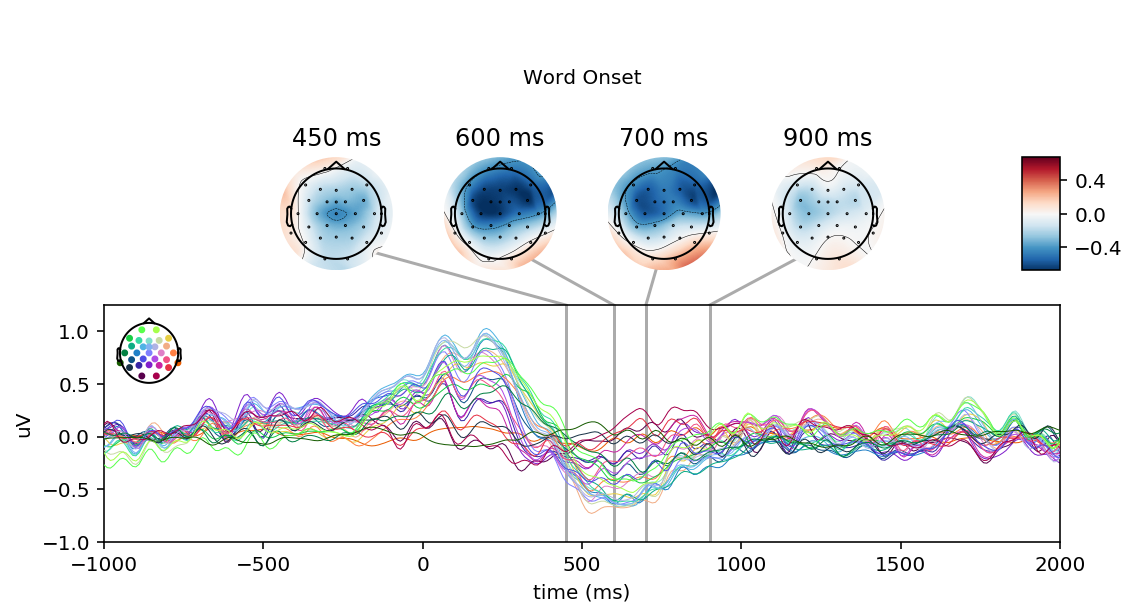

In [35]:
f = grands["word"].plot_joint(times=[.2, .66], title="Word onsets");
#f.savefig("../figs/samir_onset_butterfly.pdf")

In [26]:
fs = {k:v.copy().savgol_filter(3.5).apply_baseline()
      for k, v in grands_bins.items() if "Freq" in k
     }
colors = {str(n_):ii for ii, n_ in enumerate([int(n.split("/")[-1]) for n in fs])}

In [27]:
ses = []
for ii, this_rerp in enumerate(rerps_bins):
    all_others = mne.grand_average(
        [rp['freq'] for jj, rp in enumerate(rerps_freqs) if jj != ii]).data
    by_val = {int(name.split("/")[-1]):sum((all_others * erp.data).flatten())
              for name, erp in this_rerp.items()
              if name.startswith("Freq")}
    ses.append(pd.Series(by_val))
df_bins = pd.DataFrame(ses)

/home/jona/tools/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


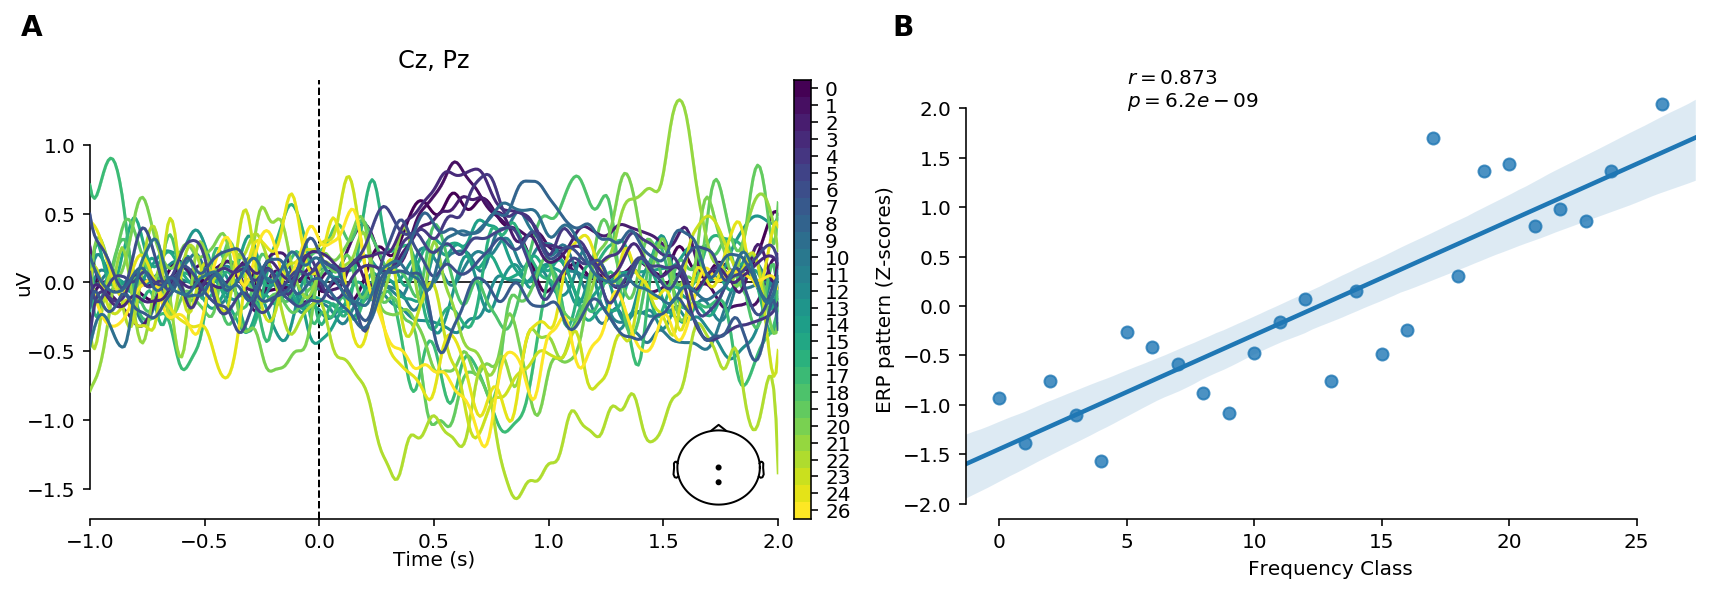

In [28]:
from scipy.stats import zscore
f = plt.figure()
f.set_size_inches((12, 4))
ax = plt.subplot(121)
mne.viz.plot_compare_evokeds(fs, split_legend=True, picks=[17, 18],
                             truncate_xaxis=True,
                             colors=colors, cmap=('viridis'),
                                axes=ax, show=False);
ax.spines['left'].set_bounds(-1.5, 1)
ax.text(-.1, 1.1, 'A', weight="bold", size=14, transform=ax.transAxes)

df_data = pd.DataFrame(zscore(df_bins.mean()), columns=["ERP pattern (Z-scores)"])
df_data["Frequency Class"] = df_bins.columns

from scipy.stats import linregress
b, i, r, p, std = linregress(df_data["Frequency Class"], zscore(df_bins.mean()))

ax = plt.subplot(122)
sns.regplot("Frequency Class", "ERP pattern (Z-scores)", df_data, ax=ax)
text = f"$r={round(r, 3)}$\n$p={round(p, 10)}$"
ax.text(5, 2, text)

ax.spines['left'].set_bounds(-2, 2)
ax.spines['bottom'].set_bounds(0, 25)
for loc in ["top",  "right"]:
    ax.spines[loc].set_visible(False)
ax.text(-.1, 1.1, 'B', weight="bold", size=14, transform=ax.transAxes)
plt.tight_layout()

#f.savefig("../figs/samir_reg.pdf", bbox_inches="tight")

# Mass-univariate stats

Note: TFCE is very slow

In [30]:
evoked = grands["freq"].copy()

from matplotlib.lines import Line2D

from mne.channels.layout import _find_topomap_coords
pos_xy = np.asarray(_find_topomap_coords(evoked.info, range(len(evoked.ch_names))))
pos_x, pos_y = pos_xy.T

def check_1020_hemisphere(name):
    """Decide if a 10-20 channel is on the left,
    right or midline, based on its name"""
    n = name[-1].lower()
    if n in {"z", '1', '2'}:
        return 'midline'
    else:
        return "left" if bool(int(n) % 2) else "right"


def do_one_hemi(evoked, pos_y, p_vals, ax, position, indices, vmin, vmax, tmin, tmax, image_alpha,
                alpha, alphas, do_contours, label_contours, unit, col=0, last_row=False):
    if col == 0:
        s = "{}\n\n{}\n".format(("Channels\n< back <       > front >"
                                 if position == "midline" else ""), position)
        ax.set_ylabel(s)
    picks = pos_y[indices].argsort()
    data = evoked.data[indices][picks] * unit

    p_vals_ = p_vals[indices][picks]
    ax.vlines(0, 0, len(picks), linestyle=":", color="grey")
    im_args = dict(extent=(tmin, tmax, 0, len(data)), aspect="auto", cmap="RdBu_r",
                   interpolation='nearest', origin="lower", vmin=vmin, vmax=vmax)
    im = ax.imshow(data, alpha=image_alpha, **im_args)

    ax.imshow(np.ma.masked_where(p_vals_ >= alpha, data), alpha=1, **im_args)
    ax.set_yticks(np.arange(len(picks)) + .5)
    ax.set_yticklabels(np.array(evoked.ch_names)[indices][picks])

    ls = list()
    if do_contours:
        for ii, this_alpha in enumerate(alphas):#[alpha]
            cs = ax.contour(p_vals_, antialiase=True, levels=[this_alpha], linestyle="--",
                            origin="lower", cmap='Greys_r', alpha=1-(1 - (ii / len(alphas))) * .666,
                            extent=(tmin, tmax, -.5, len(data)+.5),
                           )
            ls.append(Line2D((0, 0), (0, 0), color="k", label='p < ' + str(alpha),
                             alpha=1-(1 - (ii / len(alphas)))*.666)
                     )
            if label_contours:
                ax.clabel(cs, fontsize=13, fmt={this_alpha:'p < ' + str(this_alpha)},
                          levels=[this_alpha], inline_spacing=-1, antialiased=True)
    if last_row:
        ax.set_xlabel("Time (s)")

    return ls, im


def plot_image_hemi(evoked, p_vals, alpha=.05, alphas=[.05], do_contours=True, unit=1e6,
                    size=(8, 18), title='', colorbar="uV", label_contours=False, image_alpha=.33,
                    axes=None, ncols=1, col=0):
    "pvals=2D (channels, times), alpha: image mask, alphas=contours"
    import matplotlib.pyplot as plt
    from matplotlib.lines import Line2D

    from mne.channels.layout import _find_topomap_coords
    pos_xy = np.asarray(_find_topomap_coords(evoked.info, range(len(evoked.ch_names))))
    pos_x, pos_y = pos_xy.T

    hemi = np.asarray([check_1020_hemisphere(ch) for ch in evoked.ch_names])
    positions = sorted(list(set(hemi)))
    if axes is None:
        f, axes = plt.subplots(len(positions), ncols, #sharex=True
                              )
        f.set_size_inches(size)
    else:
        f = axes.flatten()[0].figure
    if ncols > 1:
        axes = axes[:, col]

    tmin, *_, tmax = evoked.times
    vmax = np.abs(evoked.data).max() * unit
    vmin = -vmax
    for jj, (ax, position) in enumerate(zip(axes, positions)):
        indices = [hemi == position]
        ls, im = do_one_hemi(evoked, pos_y, p_vals, ax, position, indices, vmin, vmax, tmin, tmax,
                             image_alpha, alpha, alphas, do_contours, label_contours, unit, col=col,
                             last_row=jj == len(positions) - 1)

    if ax.is_last_col():
        ax.legend(ls, ['p < ' + str(alpha) for alpha in alphas],
              loc='upper right', bbox_to_anchor=(1., 3.75))

    if colorbar:
        f.colorbar(im, ax=axes[:3].ravel().tolist(), fraction=.1, aspect=40, pad=.07,
                   label=colorbar, orientation="horizontal")
    axes[0].set_title(title)

    return f

In [31]:
conn, ch_names = mne.channels.find_ch_connectivity(evoked.info, 'eeg')

from functools import partial
sigma = 1e-3
stat_fun = partial(mne.stats.ttest_1samp_no_p, sigma=sigma)

X_erp = np.array([this_rerp["freq"].data.T for this_rerp in rerps_freqs])

from scipy import stats
threshold = -stats.distributions.t.ppf(0.01, len(X_erp) - 1)
tfce = dict(start=0, step=0.2)

t_obs, clusters, cluster_pv_erp, H0 = res = mne.stats.spatio_temporal_cluster_1samp_test(
    X_erp, tfce, connectivity=conn, out_type="mask", n_jobs=6, stat_fun=stat_fun,
    n_permutations=1024 * 1)

In [32]:
X_erp_2 = np.array([this_rerp["word"].data.T for this_rerp in rerps_freqs])

t_obs_2, clusters_2, cluster_pv_erp_2, H0_2 = res_2 = mne.stats.spatio_temporal_cluster_1samp_test(
    X_erp_2, tfce, connectivity=conn, out_type="mask", n_jobs=6, stat_fun=stat_fun,
    n_permutations=1024 * 1)

/home/jona/tools/miniconda3/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'antialiase', 'linestyle'
  s)


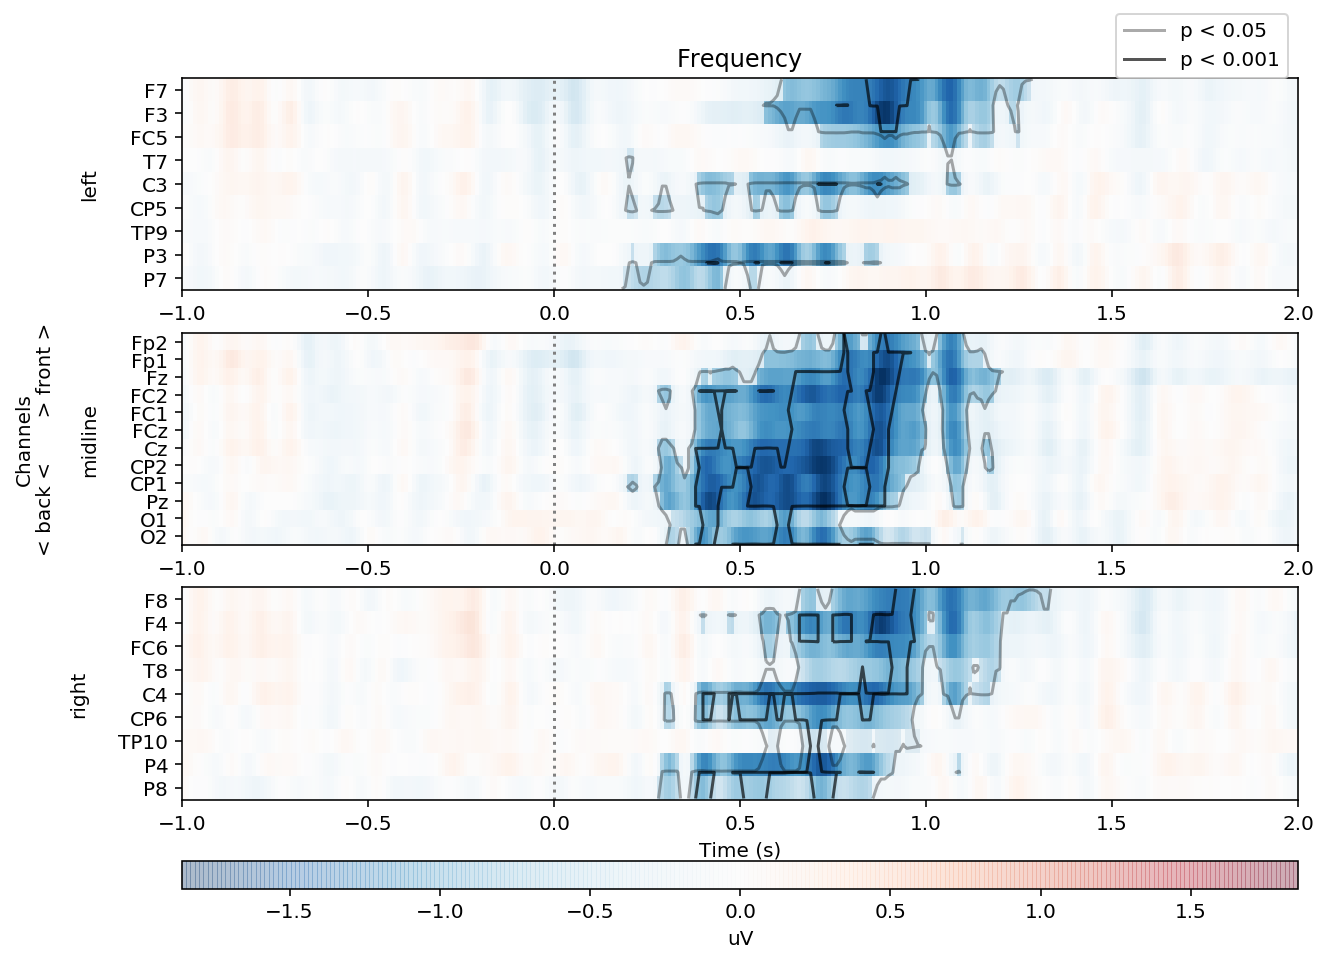

In [33]:
f, axes = plt.subplots(3, 1)
f.set_size_inches((10, 8))

f = plot_image_hemi(evoked, cluster_pv_erp.reshape(t_obs.shape).T, title="Frequency", axes=axes,
                    alphas=[ .05, .001],
               );
#f.savefig("../figs/samir_freqstats.pdf", bbox_inches='tight')